# Merian Part 3: Make your H-alpha maps!

**Explore the morphology of dwarf galaxies in H$\alpha$ using the Merian Survey data**

**Prerequisites**
- Finished the Photometric Redshift notebook and, Merian Part 1 and Part 2 notebooks

**Prerequisites**
- Need to install `reproject, photutils, cmasher, sep, statmorph`

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from IPython.display import clear_output

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

In [2]:
required_packages = ['statmorph', 'photutils', 'sep', 'cmasher', 'reproject']  # Define the required packages for this notebook

import sys
import subprocess

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Download utils.py
    !wget -q -O /content/utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    def install_packages(packages):
        for package in packages:
            try:
                __import__(package)
            except ImportError:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    # Install any missing packages
    install_packages(required_packages)
else:
    # If not in Colab, adjust the path for local development
    sys.path.append('/Users/jiaxuanl/Dropbox/Courses/ObsAstGreene/book/docs/')

# Get the directory right
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/Shareddrives/AST207/data')
else:
    os.chdir('../../_static/ObsAstroData/')

In [3]:
from utils import pad_psf, show_image

From previous notebooks, we already know the Merian survey and have played with HSC and Merian images. For those galaxies in the Merian redshift range, their H-alpha fluxes will be captured by the N708 medium-band filter. In this notebook, we will try to subtract the continuum from the N708 image to isolate the H-alpha only. In this way, we can study the spatial distribution of H-alpha, and how that correlates with other properties of the galaxy. 

Let's first open the images of a Merian dwarf:

In [4]:
cutout_dir = "./merian/cutouts/"
cat_inband = Table.read('./merian/cosmos_Merian_DR1_specz_inband.fits')
print('Total number of galaxies:', len(cat_inband))

from astropy.io import fits
i = 14
obj = cat_inband[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
name = obj['name']
print('Name:', name)

# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].data
cutout_headers = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merpsf.fits"))[0].data

# bands = list(cutouts.keys())
psf_shape = np.max(np.array([i.shape for i in psfs.values()]), 0)
# cutout_shape = np.min(np.array([i.shape for i in cutouts.values()]), 0)
# make all the psfs the same shape
for i in psfs.keys():
    psfs[i] = pad_psf(psfs[i], psf_shape)

Total number of galaxies: 152
Name: J100158.40+014812.31


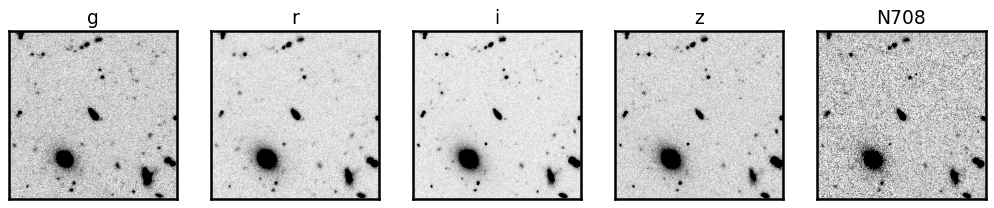

In [5]:
percl = 98 # this changes the contrast and dynamic range of the display
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys', percl=percl)
    axes[i].set_title(band, fontsize=15)

## 1. Understand PSF

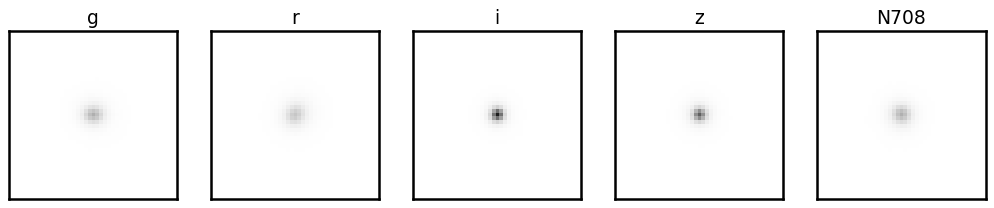

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(psfs[band], fig=fig, ax=axes[i], cmap='Greys', vmin=1e-6, vmax=8e-2)
    axes[i].set_title(band, fontsize=15)

We have played with PSFs in previous notebooks, so you must know what is a PSF (in case you forgot -- see [this](https://jgreene100.github.io/Ast207/docs/imaging/img_simulation.html#point-spread-function-psf)). The PSFs in griz+N708 bands are shown in the above figure, using the same stretching and dynamic range. Answer the following questions:

**Exercise 1:**
1. Verify that the PSFs are all normalized (i.e., the sum of all pixel values is 1).
2. By looking at the above figure, which band has the sharpest PSF? Which band has the biggest PSF? Why?
3. How can we quantify the size of the PSF?

In [7]:
## Your answer here

One way to quantify the size of the PSF is to measure its ["Full Width at Half Maximum" (FWHM)](https://en.wikipedia.org/wiki/Full_width_at_half_maximum). Although one can measure it in a non-parametric way, it is more robust to fit a parametric model (i.e., you know its analytical expression) to the PSF and then ask what the FWHM of that model is. In the cells below, we fit [a Moffat model](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat2D.html) to the PSF and calculate its FWHM. The Moffat model is generally a good description for the (core of the) PSF.

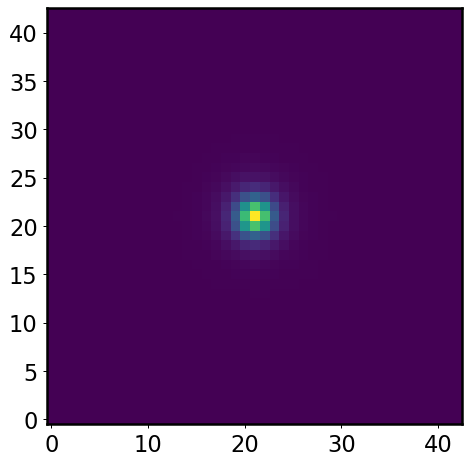

In [8]:
band = 'i'
psf = psfs[band]
plt.imshow(psf)

In [9]:
from astropy.modeling import models, fitting
y, x = np.mgrid[:psf.shape[0], :psf.shape[1]]
model = models.Moffat2D(x_0=psf.shape[1]/2, y_0=psf.shape[0]/2, amplitude=np.max(psf)) # initialize a Moffat model
fitter = fitting.LevMarLSQFitter()
best_fit = fitter(model, x, y, psf)
print(f'FWHM = {best_fit.fwhm:.3f} pix')

FWHM = 2.867 pix


<Axes: title={'center': 'residual'}>

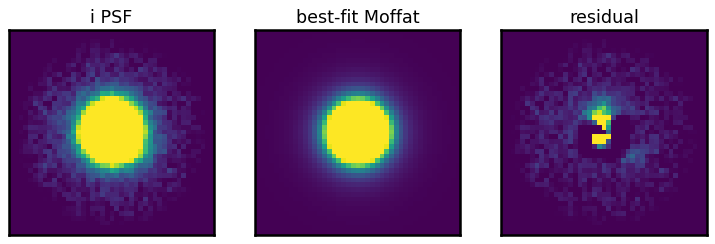

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

show_image(psf, ax=axes[0], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title=f'{band} PSF')
show_image(best_fit(x, y), ax=axes[1], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title='best-fit Moffat')
show_image(psf - best_fit(x, y), ax=axes[2], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title='residual')

Great! We get the FWHM of the i-band PSF is about 3 pixels. The pixel size is 0.168 arcsec/pixel for griz+N708 bands. So the PSF's FWHM is 0.5 arcsec. This is approximately the best resolution you can get from the ground!! Again, this resolution is not limited by the telescope, but by the atmospheric seeing.

We also notice that there are asymmetric patterns left in the residual image. That is more or less expected because the PSF of any real telescope isn't perfectly round. 

**Exercise 2:**

1. Estimate the FWHMs of the PSFs in griz+N708 bands. Which band has the best resolution? Which band has the worst resolution?
2. Recall that we want to subtract the continuum from the N708 image to get H-alpha map. Can we directly subtract a high-resolution image from an image with lower resolution?

## 2: Make H$\alpha$ map for Merian dwarfs

In order to isolate H-alpha, let's try to subtract the z-band image (representing the continuum) from the N708 image directly. However, images in different bands have slightly different sizes. We need to project them onto the same WCS before we can subtract them. 

In [11]:
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.nddata import Cutout2D
import astropy.units as u
import cmasher as cmr

We take the z-band image as the reference, and project everything else onto its WCS

In [12]:
# reproject images to line up properly
size = 60 * u.arcsec
wcs_z = WCS(cutout_headers["z"])
cutouts_reproj = {}
for i in cutouts.keys():
    wcs_i = WCS(cutout_headers[i])
    stamp_i = Cutout2D(cutouts[i], coord, size, wcs=wcs_i)
    cutouts_reproj[i], _ = reproject_interp((stamp_i.data, stamp_i.wcs), wcs_z)

In [13]:
cutouts_reproj['z'].shape, cutouts_reproj['N708'].shape # check if they have the same shape now

((357, 357), (357, 357))

Let's check how $\mathrm{N708} - z$ looks like:

Text(0.5, 1.1, 'Direct subtraction: PSFs do not match')

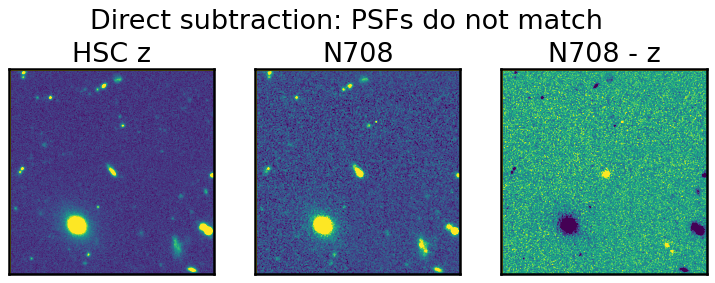

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
show_image(cutouts_reproj['z'], fig=fig, ax=axes[0], show_colorbar=False)
axes[0].set_title('HSC z')

show_image(cutouts_reproj['N708'], fig=fig, ax=axes[1], show_colorbar=False)
axes[1].set_title('N708')

show_image(cutouts_reproj['N708'] - cutouts_reproj['z'], 
           fig=fig, ax=axes[2], show_colorbar=False)
axes[2].set_title('N708 - z')

plt.suptitle('Direct subtraction: PSFs do not match', y=1.1)

It's actually already pretty good! You can see that the H-alpha is concentrated in the lower-right part of the galaxy! 

We can do a better job! The z-band image and the N708-band image do not have the same resolution. One can "blur" the z-band image by a little bit such that it matches the resolution of N708. In practice, we convolve the z-band image with a kernel, and such kernel is derived using the PSFs in both bands. The PSF matching technique is described [here](https://photutils.readthedocs.io/en/latest/user_guide/psf_matching.html) and references therein. 

We take the functions in `photutils` to perform PSF matching:

In [15]:
from photutils.psf import matching
from astropy.convolution import convolve_fft

In [23]:
worst_psf = 'N708' # indicate the band with the worst seeing
bands = ['g', 'r', 'i', 'z', 'N708']

In [24]:
cutouts_matched = {}
window = matching.CosineBellWindow(alpha=0.8) # this window supresses the high-frequency noise after Fourier transform
for band in bands:
    kernel = matching.create_matching_kernel(psfs[band], psfs[worst_psf], window=window)
    cutouts_matched[band] = convolve_fft(cutouts[band], kernel)
    if (band == worst_psf):
        cutouts_matched[band] = cutouts[band] # no need to touch the worst band
        continue

Now the images in `cutouts_matched` are all matched to the N708 resolution! Let's compare the z-band image before and after the PSF matching.

Text(0.5, 1.05, 'HSC z-band')

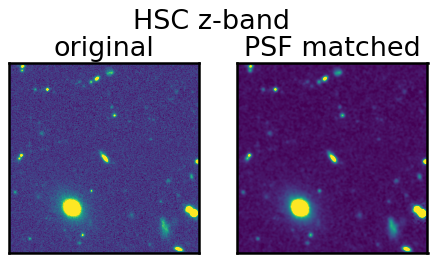

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_image(cutouts['z'], fig=fig, ax=axes[0], show_colorbar=False)
axes[0].set_title('original')

show_image(cutouts_matched['z'], fig=fig, ax=axes[1], show_colorbar=False)
axes[1].set_title('PSF matched')

plt.suptitle('HSC z-band', y=1.05)

The PSF-matched z-band image is indeed fuzzier!

Great, let's subtract the PSF-matched images:

In [26]:
# reproject images to line up properly
size = 60 * u.arcsec
wcs_z = WCS(cutout_headers["z"])
cutouts_matched_reproj = {}
for band in bands:
    wcs_i = WCS(cutout_headers[band])
    stamp_i = Cutout2D(cutouts_matched[band], coord, size, wcs=wcs_i)
    cutouts_matched_reproj[band], _ = reproject_interp(
        (stamp_i.data, stamp_i.wcs), wcs_z
    )

Text(0.5, 1.1, 'Subtraction after PSF matching')

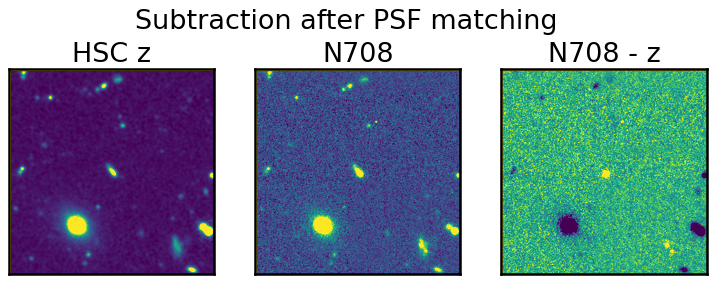

In [27]:
from utils import get_img_central_region
from astropy.visualization import ImageNormalize, LuptonAsinhStretch, make_lupton_rgb

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
show_image(cutouts_matched_reproj['z'], fig=fig, ax=axes[0], show_colorbar=False)
axes[0].set_title('HSC z')

show_image(cutouts_matched_reproj['N708'], fig=fig, ax=axes[1], show_colorbar=False)
axes[1].set_title('N708')

show_image(cutouts_matched_reproj['N708'] - cutouts_matched_reproj['z'], 
           fig=fig, ax=axes[2], show_colorbar=False)

axes[2].set_title('N708 - z')

plt.suptitle('Subtraction after PSF matching', y=1.1)

We can then define the H-alpha map as following:

In [28]:
cutouts_matched_reproj['ha'] = cutouts_matched_reproj['N708'] - 1 * cutouts_matched_reproj['z']

<Axes: >

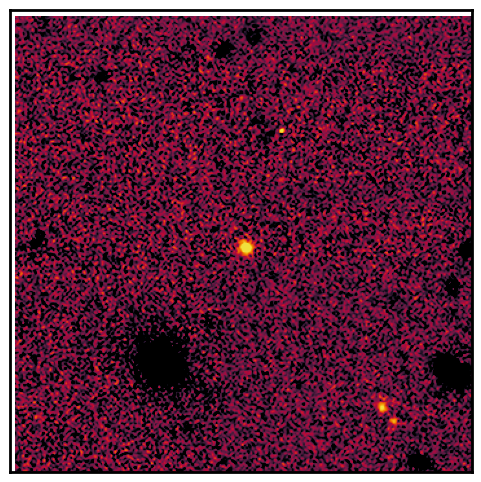

In [29]:
norm = ImageNormalize(cutouts_matched_reproj['ha'], vmin=-0.1, vmax=np.nanpercentile(cutouts_matched_reproj['ha'], 99.8),
                      stretch=LuptonAsinhStretch(stretch=0.8, Q=3))
show_image(cutouts_matched_reproj['ha'], norm=norm, cmap="cmr.ember", figsize=(6,6))

It is worth noticing that there is a galaxy with prominent H-alpha at the lower-right corner. [This galaxy](https://www.legacysurvey.org/viewer?ra=150.4881&dec=1.7973&layer=ls-dr10&zoom=16) is also actually in the Merian redshift range (you can check its [spectra](https://www.legacysurvey.org/viewer/desi-spectrum/dr1/targetid39627829528237201). It's so cool that its H-alpha is concentrated in two individual blobs.

## 3: Make pretty image with H$\alpha$ map highlighted

Let's try to make a color image (as we did before), but highlighting the H-alpha component in blue.

/Users/jiaxuanl/Softwares/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/visualization/basic_rgb.py:153: RuntimeWarning: invalid value encountered in cast
  return image_rgb.astype(output_dtype)


Text(0.5, 1.0, 'grz+H$\\alpha$ (blue)')

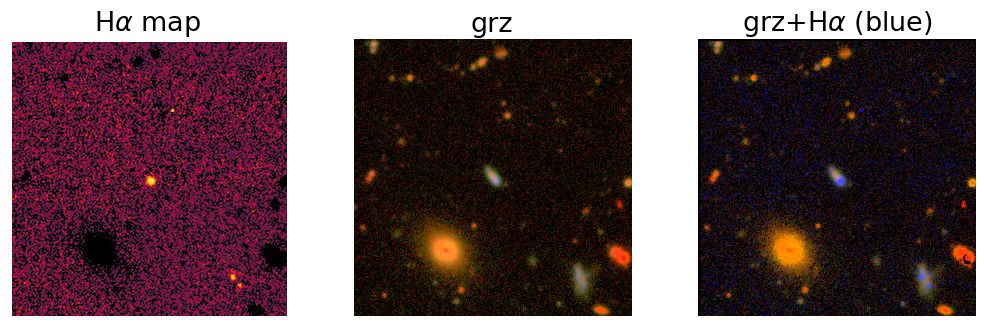

In [30]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4))

norm = ImageNormalize(cutouts_matched_reproj['ha'], vmin=-0.1, vmax=np.nanpercentile(cutouts_matched_reproj['ha'], 99.8),
                      stretch=LuptonAsinhStretch(stretch=0.8, Q=3))
ax1.imshow(cutouts_matched_reproj['ha'], norm=norm, cmap="cmr.ember", origin='lower')
ax1.axis('off')
ax1.set_title(r'H$\alpha$ map')

rgb = make_lupton_rgb(cutouts['z'], #red
                      cutouts['r'], #green
                      cutouts['g'], #blue
                      stretch=0.5, Q=6, minimum=[-0.02, -0.02, 0.06])
ax2.imshow(rgb, origin='lower')
ax2.axis('off')
ax2.set_title('grz')

rgb = make_lupton_rgb(cutouts_reproj['z'], #red
                      cutouts_reproj['r'], #green
                      1.1 * cutouts_reproj['g'] + 1.2 * cutouts_matched_reproj['ha'], #blue
                      stretch=0.5, Q=6, minimum=[-0.02, -0.02, 0.06])
ax3.imshow(rgb, origin='lower')
ax3.axis('off')
ax3.set_title(r'grz+H$\alpha$ (blue)')

**Exercise 3:**

1. Make a callable function to wrap up the above code for generating the H-alpha map for any given galaxy. The function can be like the following:
    ```python
    def make_Ha_map(idx, size=60*u.arcsec):
        # your answer
        return
    ```
3. Make H-alpha maps for 10 more galaxies! You can choose whatever you like from the catalog. But remember -- not every one of them looks as good as the example in this notebook. 